According to notebook - https://www.kaggle.com/code/c1trus/azure-maint/notebook

# Load


In [ ]:
import pandas as pd
import os


dataset_path = os.path.join("..","dataset","Azure Predictive Maintenance")

telemetry = pd.read_csv(os.path.join(dataset_path,'PdM_telemetry.csv'))
errors = pd.read_csv(os.path.join(dataset_path,'PdM_errors.csv'))
maint = pd.read_csv(os.path.join(dataset_path,'PdM_maint.csv'))
failures = pd.read_csv(os.path.join(dataset_path,'PdM_failures.csv'))
machines = pd.read_csv(os.path.join(dataset_path,'PdM_machines.csv'))

## Data preparation

In [ ]:
telemetry['temperature'] = telemetry['rotate']
telemetry = telemetry.drop(columns='rotate')

telemetry['datetime'] = pd.to_datetime(
    telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))

telemetry.describe()

In [ ]:
errors['datetime'] = pd.to_datetime(
    errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('object')

print("Total number of error records: %d" % len(errors.index))
errors.head()

In [ ]:
maint['datetime'] = pd.to_datetime(
    maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('object')

print("Total number of maintenance records: %d" % len(maint.index))
maint.head()

In [ ]:
machines['model'] = machines['model'].astype('object')

print("Total number of machines: %d" % len(machines.index))
machines.head()

In [ ]:
failures['datetime'] = pd.to_datetime(
    failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('object')

print("Total number of failures: %d" % len(failures.index))
failures.head()

# Feature Engineering

In [ ]:
fields = ['volt', 'temperature', 'pressure', 'vibration']


## Identifying Lag Features from Telemetry Data on a window of 24 hours


In [ ]:
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)


temp = []

for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

In [ ]:
temp = []
fields = ['volt', 'temperature', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                                               index='datetime',
                                               columns='machineID',
                                               values=col).resample('3H',closed='left',
                                                                                label='right',
                                                                                ).first().unstack().rolling(window=24, center=False).mean())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                                              index='datetime',
                                              columns='machineID',
                                              values=col).resample('3H',
                                                                               closed='left',
                                                                               label='right',
                                                                               ).first().unstack().rolling(window=24, center=False).std())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]

telemetry_mean_24h.head(10)

In [ ]:
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

In [ ]:
telemetry_feat.head()


## Identifying Lag Features from Error Data on a window of 24 hours

In [ ]:
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID',
                       'error1', 'error2', 'error3', 'error4', 'error5']

In [ ]:
error_count.head(10)


In [ ]:
error_count = telemetry[['datetime', 'machineID']].merge(
    error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()


In [61]:
temp = []
fields = ['error%d' % i for i in range(1, 6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                                              index='datetime',
                                              columns='machineID',
                                              values=col).resample('3H',
                                                                               closed='left',
                                                                               label='right',
                                                                               ).first().unstack().rolling(window=24, center=False).sum())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/2561389645.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H',
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/2561389645.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H',
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/2561389645.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H',
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/2561389645.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  values=col).resample('3H',
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/2561389645.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please u

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,292077.000000,292077,292077.000000,292077.000000,292077.000000,292077.000000,292077.000000
mean,50.503898,2015-07-02 21:20:32.317505280,0.037483,0.029266,0.025117,0.025541,0.018666
min,1.000000,2015-01-01 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2015-04-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,2015-07-02 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.000000,2015-10-02 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 09:00:00,2.000000,2.000000,1.500000,3.000000,2.000000
std,28.863914,NaN,0.192195,0.154875,0.140627,0.158549,0.134294


In [62]:
error_count.head()


,machineID,datetime,error1count,error2count,error3count,error4count,error5count
23,1,2015-01-04 06:00:00,0.0,0.0,0.0,0.0,0.0
24,1,2015-01-04 09:00:00,0.0,0.0,0.0,0.0,1.0
25,1,2015-01-04 12:00:00,0.0,0.0,0.0,0.0,1.0
26,1,2015-01-04 15:00:00,0.0,0.0,0.0,0.0,1.0
27,1,2015-01-04 18:00:00,0.0,0.0,0.0,0.0,1.0


## Identifying Days Since Last Replacement using Maintenance on a window of 24 hours

In [63]:
import numpy as np

comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID',
                    'comp1', 'comp2', 'comp3', 'comp4']

comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime',
                                                          'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

In [64]:
comp_rep


,datetime,machineID,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,False,True,False,False
90,2014-07-16 06:00:00,1,False,False,False,True
121,2014-07-31 06:00:00,1,False,False,True,False
359,2014-12-13 06:00:00,1,True,False,False,False
400,2015-01-01 06:00:00,1,0,0,0,0
...,...,...,...,...,...,...
876822,2016-01-01 02:00:00,100,0,0,0,0
876922,2016-01-01 03:00:00,100,0,0,0,0
877022,2016-01-01 04:00:00,100,0,0,0,0
877122,2016-01-01 05:00:00,100,0,0,0,0


In [65]:
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(),
                 comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/420400409.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/420400409.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/420400409.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykern

In [66]:
comp_rep

,datetime,machineID,comp1,comp2,comp3,comp4
400,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
502,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
602,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
702,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
802,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
...,...,...,...,...,...,...
876822,2016-01-01 02:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00
876922,2016-01-01 03:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00
877022,2016-01-01 04:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00
877122,2016-01-01 05:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00


In [67]:
for comp in components:
    comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")

comp_rep.describe()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/4062175902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/4062175902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_4

,datetime,machineID,comp1,comp2,comp3,comp4
count,876823,876823.000000,876823.000000,876823.000000,876823.000000,876823.000000
mean,2015-07-02 18:04:36.939815424,50.499106,53.517611,51.537350,52.722043,53.826833
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.000000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.000000,32.791667,29.666667,32.250000,32.500000
75%,2015-10-02 00:00:00,75.000000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866046,62.490219,59.271457,58.875826,59.704062


In [68]:
comp_rep.head()


,datetime,machineID,comp1,comp2,comp3,comp4
400,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
502,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
602,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
702,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
802,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


## Machine Features: Descriptive Statistics about the Machine


In [69]:
final_feat = telemetry_feat.merge(
    error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(
    comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat.head()

,machineID,datetime,voltmean_3h,temperaturemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,temperaturesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-04 06:00:00,186.092896,451.641253,107.989359,55.308074,13.489090,62.185045,5.118176,4.904365,...,0.0,0.0,0.0,0.0,22.000,217.000,157.000,172.000,model3,18
1,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,0.0,0.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18
2,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,0.0,0.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18
3,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,0.0,0.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18
4,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,0.0,0.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18


In [70]:
final_feat.describe()


,machineID,datetime,voltmean_3h,temperaturemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,temperaturesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292698.000000,292698,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,...,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000,292698.000000
mean,50.501268,2015-07-02 20:05:53.336203520,170.784219,446.575340,100.864117,40.386506,13.300159,44.453806,8.886790,4.441220,...,0.037758,0.029442,0.025289,0.025712,0.018841,53.444887,51.452085,52.640758,53.737431,11.329497
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2015-04-02 15:00:00,164.452628,427.534759,96.239740,38.147926,8.027559,26.903316,5.370347,2.684286,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,7.000000
50%,50.000000,2015-07-02 21:00:00,170.436600,448.367055,100.236344,40.146085,12.496284,41.792210,8.347255,4.173691,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.125000,32.375000,12.000000
75%,75.000000,2015-10-02 03:00:00,176.619220,468.434339,104.409335,42.228807,17.690501,59.099500,11.791536,5.900380,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.375000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,2.000000,1.500000,3.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.863879,NaN,9.509413,33.161392,7.423015,3.481097,6.967073,23.216722,4.656677,2.320464,...,0.192877,0.155121,0.140891,0.159066,0.134849,62.477055,59.241774,58.860338,59.673951,5.827516


# Constructing Labels


In [71]:
labeled_features = final_feat.merge(
    failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(
    method='bfill', limit=7)
labeled_features = labeled_features.fillna('none')
labeled_features.head()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/1061303446.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  labeled_features = labeled_features.fillna(


,machineID,datetime,voltmean_3h,temperaturemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,temperaturesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-04 06:00:00,186.092896,451.641253,107.989359,55.308074,13.489090,62.185045,5.118176,4.904365,...,0.0,0.0,0.0,22.000,217.000,157.000,172.000,model3,18,none
1,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,0.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
2,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,0.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
3,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,0.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
4,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,0.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4


In [73]:
labeled_features['failure'].value_counts()


failure
none     286633
comp2      2136
comp1      1635
comp4      1340
comp3      1037
Name: count, dtype: int64

# XGBoost Binary classification - Error / No Error

In [75]:
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

last_train_date, first_test_date = threshold_dates[0]

y_train = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
X_train = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime', 'machineID', 'failure'], axis=1))


In [76]:
# Binary class
dict_map = {'none': 0,
            'comp1': 1,
            'comp2': 1,
            'comp3': 1,
            'comp4': 1,
           }

y_train = y_train.replace(dict_map)
y_train.value_counts()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/769967286.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace(dict_map)


failure
0    165353
1      3685
Name: count, dtype: int64

In [77]:
from xgboost import XGBClassifier
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [78]:
MODELS_PATH = os.path.join("..","store","models")
model.save_model(os.path.join(MODELS_PATH,"xgboost_binary.json"))

## Evaluation

In [80]:
y_test = labeled_features.loc[labeled_features['datetime'] >= first_test_date, 'failure']
X_test = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] >= first_test_date].drop(['datetime',
                                                                                                    'machineID',
                                                                                                    'failure'], axis=1))

In [81]:
y_test = y_test.replace(dict_map)
y_test.value_counts()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/795886439.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace(dict_map)


failure
0    120485
1      2454
Name: count, dtype: int64

In [82]:
y_test = y_test.to_frame()
y_test['pred'] = list(model.predict(X_test))
y_test['pred'].value_counts()

pred
0    120476
1      2463
Name: count, dtype: int64

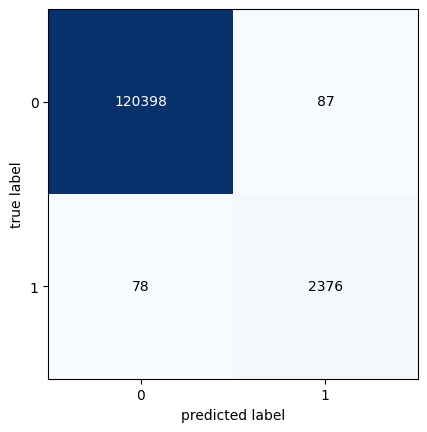

In [84]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_target=y_test['failure'],
                      y_predicted=y_test['pred'],
                      binary=True)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [85]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

recall = recall_score(y_test['failure'], y_test['pred'])

print("Recall: ", recall)

precision = precision_score(y_test['failure'], y_test['pred'])

print("Precision: ", precision)

Recall:  0.9682151589242054
Precision:  0.9646772228989038


# XGBoost multiclass - Type of error prediction

In [87]:
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

last_train_date, first_test_date = threshold_dates[0]

y_train = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
X_train = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                    'machineID',
                                                                                                    'failure'], axis=1))

In [89]:
dict_map = {'none': 0,
            'comp1': 1,
            'comp2': 2,
            'comp3': 3,
            'comp4': 4,
           }

y_train = y_train.replace(dict_map)
y_train.value_counts()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/3668342312.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace(dict_map)


failure
0    165353
2      1199
1      1063
4       796
3       627
Name: count, dtype: int64

In [90]:
from xgboost import XGBClassifier

# Create an instance of the XGBClassifier
model = XGBClassifier(objective='multi:softprob')

# Fit the model to the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [91]:
MODELS_PATH = os.path.join("..","store","models")
model.save_model(os.path.join(MODELS_PATH,"xgboost_multiclass.json"))

## Evaluation

In [94]:
y_test = labeled_features.loc[labeled_features['datetime'] >= first_test_date, 'failure']
X_test = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] >= first_test_date].drop(['datetime',
                                                                                                    'machineID',
                                                                                                    'failure'], axis=1))

In [98]:
X_test.head()

,voltmean_3h,temperaturemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,temperaturesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,temperaturemean_24h,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
1676,157.906797,436.223066,99.668710,41.927731,14.311694,48.891917,8.484343,5.750070,170.652027,445.221734,...,0.0,12.875,27.875,57.875,42.875,18,False,False,True,False
1677,177.484300,474.384707,95.465206,36.536615,11.467069,52.263950,7.914226,5.928830,170.804173,446.963574,...,0.0,13.000,28.000,58.000,43.000,18,False,False,True,False
1678,160.722230,454.141020,96.239534,37.227385,11.720061,60.893656,16.558994,0.510792,169.589308,444.203774,...,0.0,13.125,28.125,58.125,43.125,18,False,False,True,False
1679,164.327403,483.343506,93.766954,37.099411,11.158956,36.377145,5.826244,5.443107,168.178133,446.728994,...,0.0,13.250,28.250,58.250,43.250,18,False,False,True,False
1680,168.114265,459.958711,100.904301,40.966879,21.079445,70.966810,8.388908,4.248384,169.966161,444.893159,...,0.0,13.375,28.375,58.375,43.375,18,False,False,True,False


In [95]:
y_test = y_test.replace(dict_map)
y_test.value_counts()

/var/folders/wd/xc5lcvsx6cddcbbjh3kklb5c0000gn/T/ipykernel_49438/1381593820.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace(dict_map)


failure
0    120485
2       931
1       572
4       541
3       410
Name: count, dtype: int64

In [96]:
y_test = y_test.to_frame()
y_test['pred'] = list(model.predict(X_test))
y_test['pred'].value_counts()

pred
0    120454
2       942
1       586
4       539
3       418
Name: count, dtype: int64

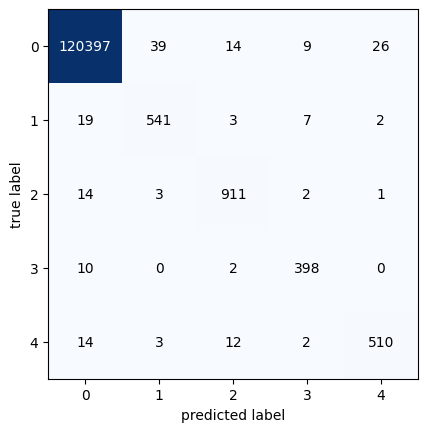

In [97]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_target=y_test['failure'],
                      y_predicted=y_test['pred'],
                      binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()